In [1]:
# Importing everything
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

In [2]:
def create_bell_pair():
    """
    Returns:
        QuantumCircuit: Circuit that produces a Bell pair
    """
    qc = QuantumCircuit(2)
    qc.h(1)
    qc.cx(1, 0)
    return qc

In [3]:
def encode_message(qc, qubit, msg):
    """Encodes a two-bit message on qc using the superdense coding protocol
    Args:
        qc (QuantumCircuit): Circuit to encode message on
        qubit (int): Which qubit to add the gate to
        msg (str): Two-bit message to send
    Returns:
        QuantumCircuit: Circuit that, when decoded, will produce msg
    Raises:
        ValueError if msg is wrong length or contains invalid characters
    """
    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1] == "1":
        qc.x(qubit)
    if msg[0] == "1":
        qc.z(qubit)
    return qc

In [4]:
def decode_message(qc):
    qc.cx(1, 0)
    qc.h(1)
    return qc

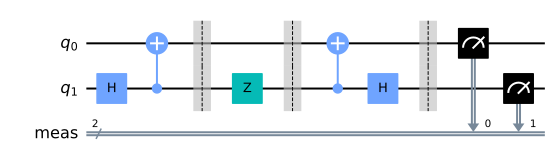

In [5]:
# Charlie creates the entangled pair between Alice and Bob
qc = create_bell_pair()

# We'll add a barrier for visual separation
qc.barrier()

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 1. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = '10'
qc = encode_message(qc, 1, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
qc = decode_message(qc)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw()

{'10': 1024}


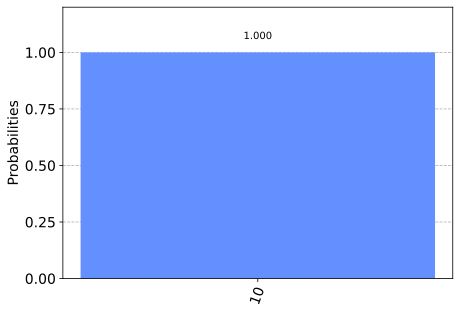

In [6]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

In [7]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)

least busy backend:  ibmq_quito


In [8]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


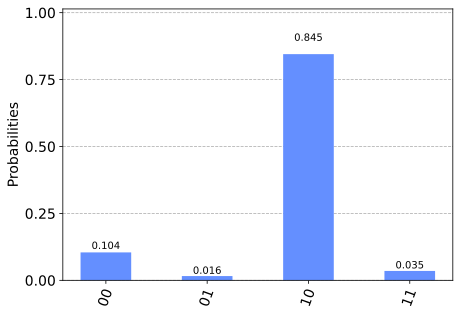

In [9]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))